In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

# Age + Date_of_birth
Date_of_birth obsahuje formáty:<br>
YYYY-MM-DD 00 00 00<br>
DD-MM-YYYY  0:00:00<br>
DD-MM-YYYY (Obsahuje chyby - dôkazom toho je hneď prvý záznam s 02-10-2029, dalo by sa to opraviť na 1929 a tak by to korešpondovalo s rokmi, no pandas nevie prečítať posledné 2 čísla YY)<br>
Z nasledujúceho výstupu je možné odhadnúť treshold na základe ktorého by sa dalo nájsť storočie pre každý rok (ak ich všetky majú na rovnako). Snahou bolo to transformovať do presných rokov, no po dlhom trápení sa to radšej zjednodušilo do tvaru DD-MM-YY.

Age obsahuje jeden záznam s rokmi 455, aj keď korešponduje s dátumom narodenia, zahodíme ho lebo aj tak ním nestratíme veľa info pri klasifikácii.

In [3]:
train['date_of_birth'] = train['date_of_birth'].str.extract('(\d*-\d\d-\d\d)', expand=True)
train.drop(train[train['age'] > 120].index, inplace=True)
train['date_of_birth'] = pd.to_datetime(train['date_of_birth'])
train['date_of_birth'] = train['date_of_birth'].dt.strftime('%d-%m-%y')
train[(train['age'] < 20)][112:116][['age', 'date_of_birth']]

age date_of_birth
2421  18.0      18-12-99
2444  18.0      02-06-00
2445  18.0      14-09-99
2504  19.0      13-03-99

# query - hypop (OK)

# TSH, TSH measured (OK)
Obsahuje nevyplnené hodnoty, ktoré vyplníme mediánom. Outliery majú vysoké hodnoty ktoré je treba vyvážiť s ostatnými hodnotami. Kedže obsahuje hodnoty menšie ako 1, namiesto použitia logaritmu použijeme odmocninu.

### Stará distribúcia

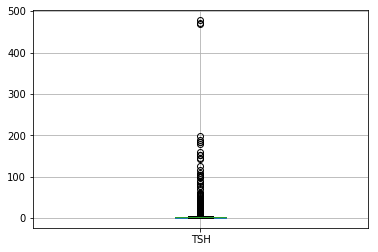

In [4]:
train.boxplot(column='TSH')         # filtrovany boxplot

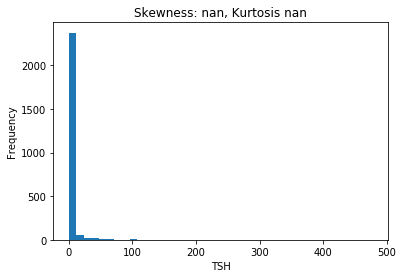

In [5]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['TSH']), (stats.kurtosis(train['TSH']))))
plt.xlabel('TSH')
train.TSH.plot(kind='hist', bins = 40)

### Transformácia distribúcie

In [6]:
print(train['TSH'].head())
train['TSH'].fillna(value=train['TSH'].median(), inplace=True)
train['TSH'] = train['TSH'].apply(lambda x: math.sqrt(x))
print(train['TSH'].head())

0    13.00
1      NaN
2     2.00
3     2.70
4     0.92
Name: TSH, dtype: float64
0    3.605551
1    1.183216
2    1.414214
3    1.643168
4    0.959166
Name: TSH, dtype: float64


### Nová distribúcia

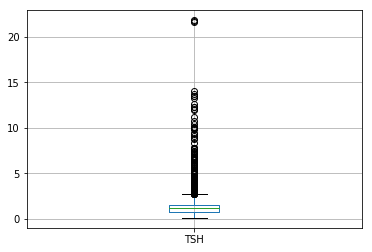

In [7]:
train.boxplot(column='TSH')

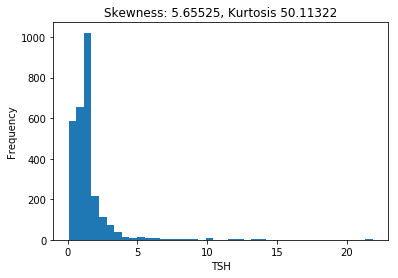

In [8]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['TSH']), (stats.kurtosis(train['TSH']))))
plt.xlabel('TSH')
train.TSH.plot(kind='hist', bins = 40)

# FTI
Pretypujeme typ object na float. Chýbajúce otáznikové hodnoty nahradíme mediánom.

In [9]:
train.loc[train['FTI'] == '?', 'FTI'] = -1
train['FTI'] = train['FTI'].astype(float) 
print('Pocet outlierov:', train[(train['FTI'] == -1)].count().iloc[0])
pom = train[(train['FTI'] > -1)]
print('Median:', pom['FTI'].median())
train.loc[train['FTI'] == -1, 'FTI'] = pom['FTI'].median()

Pocet outlierov: 295
Median: 107.0


### Distribúcia

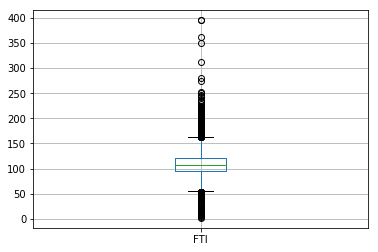

In [10]:
train.boxplot(column='FTI')

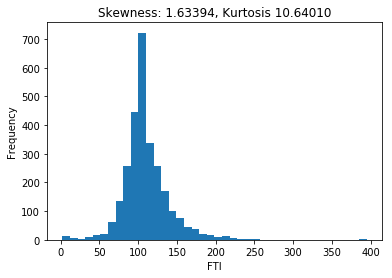

In [11]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['FTI']), (stats.kurtosis(train['FTI']))))
plt.xlabel('FTI')
train.FTI.plot(kind='hist', bins = 40)

# TBG

Pozostáva len z otáznikov, tento atribút môžeme zahodiť.

In [12]:
train.drop(columns=['TBG'], inplace=True)
train.drop(columns=['TBG measured'], inplace=True)

# fnlwgt
V nasledujúcich dvoch obrázkoch je vidiet veľká vychýlenosť hodnôt

### Stará distribúcia

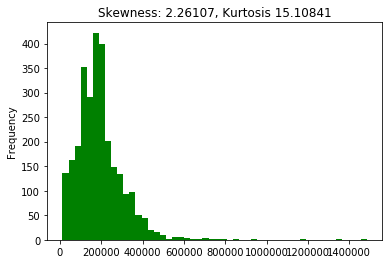

In [13]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['fnlwgt']), (stats.kurtosis(train['fnlwgt']))))
train.fnlwgt.plot(kind='hist', bins = 50, color="Green")

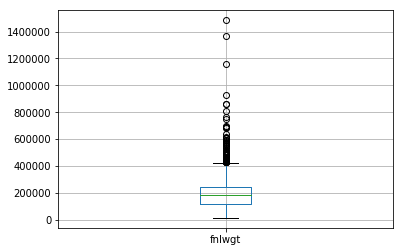

In [14]:
train.head()
train.boxplot(column='fnlwgt')

Outliery sú vo vysokách hodnotách. Na to, aby boli viac vyváženejšie s ostatnými, aplikujeme funkciu logaritmus.

### Nová distribúcia

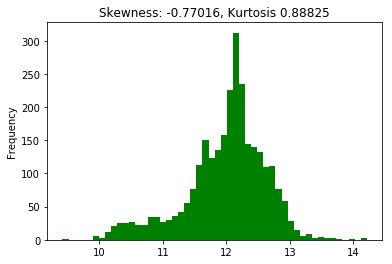

In [15]:
train['fnlwgt'] = train['fnlwgt'].apply(lambda x: math.log(x))    # aplikovanie funkcie logaritmus
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['fnlwgt']), (stats.kurtosis(train['fnlwgt']))))
train.fnlwgt.plot(kind='hist', bins = 50, color="Green")

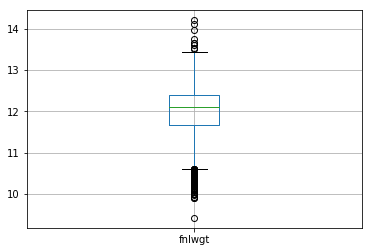

In [16]:
train.boxplot(column='fnlwgt')

# education-num
Obsahuje vychýlene hodnoty, ktoré stačí vydeliť číslom 100, v prípade záporného čísla číslom -100 a pretypovať typ float na integer.

### Nová distribúcia

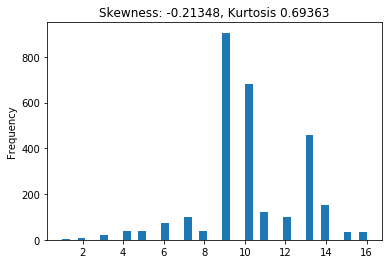

In [17]:
train.loc[train['education-num'] < 0, 'education-num'] /= -100
train.loc[train['education-num'] > 99, 'education-num'] /= 100
train['education-num'] = train['education-num'].astype(int) 

plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['education-num']), (stats.kurtosis(train['education-num']))))
train['education-num'].plot(kind='hist', bins = 40)

# capital-gain
- vyplnanie nevyplnenych hodnot by sa mohlo na zaklade occupation(pripadne nieco ine), ak sa nenajde vztah, nahradit hodnotou 0, kedže ich tam je väčšina (NOT YET DONE)
- transformácia 12 outlierov cez nahradenie mediánom z intervalu hodnôt 10000 až 99998

In [18]:
train['capital-gain'].describe()   # vacsina hodnot 0

count     2519.000000
mean       933.210401
std       7191.496095
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [19]:
train.loc[train['education-num'] < 0, 'education-num'] /= -100
train.loc[train['education-num'] > 99, 'education-num'] /= 100

train.loc[(train['sex'] == '?') & (train['pregnant'] == 't'), 'sex'] = 'F'


train['education-num'] = train['education-num'].astype(int) 


print('Pocet outlierov:', train[(train['capital-gain'] == 99999)].count().iloc[0])   # počet outlierov
pom = train[(train['capital-gain'] > 10000) & (train['capital-gain'] != 99999)]
print('Median:', pom['capital-gain'].median())                              # median
train.loc[train['capital-gain'] == 99999, 'capital-gain'] = pom['capital-gain'].median()

Pocet outlierov: 12
Median: 15024.0


# Capital-loss (OK)

# hours per week
Neobsahuje chýbajúce hodnoty, má však vychýlené hodnoty 99 ktoré by sa mohli nahradiť najfrekventovanejšou hodnotou 40. (ALEBO NA ZAKLADE INEHO ATRIBUTU).

In [20]:
train['hours-per-week'].describe()
#train.loc[train['hours-per-week'] == 99, 'hours-per-week'] = 40

count    2799.000000
mean       38.698821
std        12.703063
min         1.000000
25%        35.000000
50%        40.000000
75%        40.000000
max        99.000000
Name: hours-per-week, dtype: float64

# class + class number
rozdelenie atribútu class na 2

In [21]:
pom = train['class'].str.split('.[|_]', 1, expand=True)   # rename(columns={0:'class', 1:'class number'})
#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['class'], inplace=True)
train['class'] = pom[0]
train['class number'] = pom[1]
train['class number'] = train['class number'].astype(int) 
train['class number'].describe()


count    2799.000000
mean     1895.972847
std      1091.149836
min         1.000000
25%       957.000000
50%      1914.000000
75%      2838.000000
max      3772.000000
Name: class number, dtype: float64

In [23]:
train.to_csv('repaired.csv')